# Analysis of Crowdfunding Projects

### Data Description

Kickstarter.com is a crowd funding website where creators post descriptions of projects they want to create, and individuals contribute some amount of personal money to finance the project. In return for funding, contributors typically get a wide range of “Backer Rewards”. The rewards differ depending on the type of project. For example, a book/video project will typically issue a digital copy of the final product to backers that donate above a given amount. The scope of projects can vary widely, from the initial factory runs of complex hardware products. One creator simply requested ten dollars so he could make some potato salad and instead raised $55,000 and threw a crazy party

### Data Source

Webrobots.io runs a monthly scrape of all Kickstarter projects available on the Kickstarter website. The resulting data are available as both csv and json files, and each package covers a number of projects on the website from the start date (April 21st 2009) until the scrape date. From April 2015, Kickstarter began limiting the number of search results for each category. As a result, the numbers of historical results displayed are limited. Webrobots started running scrapes in multiple sub-categories to capture more instances, and as a result, there are multiple entries for several projects.

### Dates of Study

The scrape data that I'm working with was taken from Kickstarter.com in March of 2019. The scrape data includes both historical and current projects, so there's a wide variety of dates captured here.

# Data issues

### Inconsistent Dates

Kickstarter.com limits the number of search results shown for each category of project (ex. 'Film & Video', or 'Publishing'). Because of this limit and because the number of projects in each category varies based on their relative popularity, the active dates for projects across different categories are not all the same. As we'll see later, the popularity of the Kickstarter.com website fluctuates over time, so different launch dates can affect a project's chances of success

### Missing, incorrect or duplicate data

The overall quality of the dataset is very good, with very few pieces of missing data.

# Scope and Goals

### Audience and Business Need

This project is aimed at creators that are interested launching projects on Kickstarter's platform. Kickstarter campaigns are "all or nothing", meaning if a campaign doesn't reach the funding goal, all of the funds are returned to backers. For this reason, it's important for campaigns to carefully consider how their project is presented

### Previous Work 

There's been a lot of work published using Kickstarter datasets in the past. Most of the past work has focused on trying to predict whether a project will achieve their funding goal based on characteristics such as funding goal, project  category, and number of backers. While that's interesting from a technical/model optimization view, actionable information for creators is limited so far. 

Citations for previous work is given in Appendix B at the end of this notebook

### Project Goal

In light of the previous work done and the popularity of the dataset, this project attempts to approach this dataset from an original angle. Through an exploratory analysis of the data, it seems that the likelihood of success for projects is their ability to "crack" the sorting algorithms that Kickstarter and Indiegogo use to display content on their home page.

With this new information, this project aims to train a model that predicts whether projects will reach their funding goal using logistic regression. From there, we'll contrast the importance of being selected by the site's algorithms on funding success between Kickstarter and Indiegogo.

### Importance

Crowdfunding sites have three main stakeholders:
- The platform itself
- The creators that launch campaigns on the site
- The people that pledge funds to projects

The platforms themselves want to tune their sorting algorithms to be sure the projects being selected are interesting to the users of the platform as a whole. 

The creators that use the platform need to be aware of algorithm impacts because it allows them to re-focus who they're pitching their project to. On platforms where algorithm selection heavily affects project success, creators want to target their project pitch to the site as a whole, rather than focus just their particular market

Additionally, it's important for individuals to understand why they're being shown the content that appears on the platform's homepage. Both Kickstarter and Indiegogo market themselves as being a way for creators to connect with a wider audience and bring their ideas to life. Being aware of the affects that algorithm has on what projects get funded helps consumers make more informed decisions about how they spend their money. 



# Data Cleaning and Manipulation

### JSON Formatting

Many of columns in the original dataset were returned as JSON objects during the webrobots scrape. When exporting to a .csv file, and then importing into Pandas, the JSON formatting was lost. The cleaning script made for this project re-applied the JSON formatting, and then pulled the relevant information back out

### Interpreted Data
Some columns were made with interpreted data. Time deltas were calculated between:
* Campaign launch date and campaign creation date
* Campaign launch date and campaign deadline
* Campaign launch date and date funding goal was reached

Natural Language Processing was run on project titles and descriptions to better define project differences. The data from the NLP analysis was used to score project descriptions on their active phrasing and whatever other criteria I make up 

### Pruning and other cleaning
The remaining cleaning work has been selecting the data relevant to the project. The original dataset contained contained image url's, and duplicates of data available in other columns. These items were removed from the dataset used for analysis

### Date formats 

All of the columns that are time/date related are in epoch time, and I've left it that way to make things easier to do math

### External Data

Data pulled from IndieGoGo has been merged in with the Kickstarter dataset for comparison

In [1]:
#Import libraries needed for analysis
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pdb
import time
import re
import os
import math as mt

url = 'https://tufts.box.com/shared/static/939cuad4z6ieo8njf3ya58a603q4enyh.csv'
if not os.path.exists('2019KickDataCleaned.csv'):
    df = pd.read_csv(url)
else:
    df = pd.read_csv('2019KickDataCleaned.csv', index_col = 0)

df.drop(columns = ['subcats'], inplace = True)
df = df.drop_duplicates(subset = ['id'])
len(df)

181302

### Project states

There are four different states listed for each project in the dataset:

| State | Description|
|:---:|:---:|
|Live | Project is currently actively fundraising|
|Cancelled | Project was cancelled by the creators before the deadline | 
|Suspended | The project was suspended by Kickstarter for not meeting some criteria|
|Succesful| The project has met or exceeded the funding goal |
|Failed| The project failed to meet their funding goal| 

Since this project aims to analyze factors that make projects successful, I've filtered the dataset to include only projects that are either successful or failed

# Merge in External Data

### Alexa Site Traffic Ranking data

I snagged the Alexa global traffic ranking for Kickstarter.com for the last three years. Let's take a look and see if there's any correlation between the site's traffic ranking and the success rate of projects. I only had access to the last three years worth of ranking data, so some projects will be missing information

I'm using the launch date as a foreign key to match with Kickstarter's Alexa ranking, so I have to convert the timestamp to M/D/YYYY format

Once the timestamps are converted, merge the Alexa ranking data in with the Kickstarter data

In [2]:
url = 'https://tufts.box.com/shared/static/tyrjjx8afos74m7ejwia7vwt6uiyr996.csv' #Read the Alexa data
alexa = pd.read_csv(url, skiprows = 6) 
kickRank = pd.DataFrame()
kickRank['Date'] = alexa['Date']
kickRank['Rank'] = alexa['kickstarter.com']

#Convert the launch date timestamp (in epoch time) to M/D/YYYY format
df['launch_date'] = df.apply(lambda x: time.strftime('%-m/%-d/%Y', time.localtime(x['launched_at'])), axis = 1)

#Merge the two dataframes together on the launch date column with a left join
df = df.merge(kickRank, how = 'left', left_on = 'launch_date', right_on = 'Date')

In [3]:
df.head()

,Unnamed: 0,backers_count,blurb,country,created_at,creator,currency,deadline,fx_rate,goal,...,fullcats,city,creLauDelta,lauDeadDelta,staLauDelta,source,funds_raised_percent,launch_date,Date,Rank
0,0,9,A comedy web series about the inherently funny...,US,1489891481,915430313,USD,1494132705,1.000000,5000.0,...,film & video,"Austin, TX",19,30,30,Kickstarter,10.160000,4/7/2017,4/7/2017,548.0
1,1,36,"Cabo y un Capitán, dos soldados villistas, tra...",MX,1508479978,1011928721,MXN,1512917074,0.052034,65000.0,...,film & video,"Mexico City, Mexico",16,35,35,Kickstarter,5.226900,11/5/2017,11/5/2017,528.0
2,2,61,We're building the new home of Māori Theatre a...,NZ,1426499822,1902194044,NZD,1429596000,0.685030,10000.0,...,theater,"Auckland, NZ",7,28,28,Kickstarter,78.343402,3/23/2015,NaN,NaN
3,3,1730,Comic-book stories celebrate women who crack c...,US,1482813229,121124061,USD,1489666144,1.000000,40000.0,...,comics,"Scottsdale, AZ",49,29,29,Kickstarter,243.617500,2/14/2017,2/14/2017,589.0
4,4,183,"A Victorian “gaslamp” lesbian romance, set in ...",US,1506228739,484654302,USD,1510473540,1.000000,2000.0,...,games,"San Francisco, CA",16,32,32,Kickstarter,195.550000,10/10/2017,10/10/2017,503.0


### Convert Foreign Currencies to USD terms

There's a number of projects that originated outside of the US. For these projects, the funding goals are in a different currency. In order to clean up the dataframe for analysis, convert these into USD terms.

Kickstarter.com was kind enough to include the prevailing currency exchange rate at the time of the project, so I'll use that for the conversion

In [4]:
# Multiply the goal by the fx rate
df['goal'] = df.apply(lambda x: (x['goal'] * x['fx_rate']), axis = 1) 

In [5]:
# Check that the merge was successful and did what I wanted
df.head()

,Unnamed: 0,backers_count,blurb,country,created_at,creator,currency,deadline,fx_rate,goal,...,fullcats,city,creLauDelta,lauDeadDelta,staLauDelta,source,funds_raised_percent,launch_date,Date,Rank
0,0,9,A comedy web series about the inherently funny...,US,1489891481,915430313,USD,1494132705,1.000000,5000.0000,...,film & video,"Austin, TX",19,30,30,Kickstarter,10.160000,4/7/2017,4/7/2017,548.0
1,1,36,"Cabo y un Capitán, dos soldados villistas, tra...",MX,1508479978,1011928721,MXN,1512917074,0.052034,3382.2282,...,film & video,"Mexico City, Mexico",16,35,35,Kickstarter,5.226900,11/5/2017,11/5/2017,528.0
2,2,61,We're building the new home of Māori Theatre a...,NZ,1426499822,1902194044,NZD,1429596000,0.685030,6850.2957,...,theater,"Auckland, NZ",7,28,28,Kickstarter,78.343402,3/23/2015,NaN,NaN
3,3,1730,Comic-book stories celebrate women who crack c...,US,1482813229,121124061,USD,1489666144,1.000000,40000.0000,...,comics,"Scottsdale, AZ",49,29,29,Kickstarter,243.617500,2/14/2017,2/14/2017,589.0
4,4,183,"A Victorian “gaslamp” lesbian romance, set in ...",US,1506228739,484654302,USD,1510473540,1.000000,2000.0000,...,games,"San Francisco, CA",16,32,32,Kickstarter,195.550000,10/10/2017,10/10/2017,503.0


### IndieGoGo Data

Webrobots.io also runs a monthly scrape of the indiegogo website. Since there's already been a large amount of work done on Kickstarter data in the past, I want to try and make some unique analyses using a new dataset.

I grabbed the most recent version of the indiegogo dataset, and now I'm going to merge it with my Kickstarter dataset

In [6]:
#Start by taking a look at the indiegogo dataset
url = 'https://tufts.box.com/shared/static/on2cmdxc4vqpm2dutaaf7l8764ktq0u5.csv'
indie = pd.read_csv('https://tufts.box.com/shared/static/on2cmdxc4vqpm2dutaaf7l8764ktq0u5.csv')
#Drop columns that are unrelatd to the original kickstarter dataset
indie.drop(labels = ['bullet_point', 'category_url', 'clickthrough_url', 'image_url', 'is_pre_launch', 'offered_by', 
                     'price_offered', 'product_id', 'product_stage', 'project_type', 'price_retail', 
                     'perk_goal_percentage', 'tags'], axis = 1, inplace = True)

In [7]:
indie.head()

,category,close_date,currency,funds_raised_amount,funds_raised_percent,is_indemand,open_date,perks_claimed,project_id,source_url,tagline,title
0,Home,2018-07-16T23:59:59-07:00,GBP,10694.0,1.065059,True,2018-07-15T23:59:59-07:00,58.0,2397370,https://www.indiegogo.com/explore/all?project_...,Make a brew for two with one press using the A...,2POUR An Accessory For Aeropress Coffee Maker
1,Web Series & TV Shows,2017-09-12T23:59:59-07:00,AUD,30.0,0.003000,False,2017-07-14T06:19:44-07:00,0.0,2152925,https://www.indiegogo.com/explore/all?project_...,This street is the stage where the theatre mee...,Hustle Street - A musical
2,Photography,2013-02-13T23:59:59-08:00,USD,7060.0,0.415294,False,2012-12-10T09:05:14-08:00,65.0,291347,https://www.indiegogo.com/explore/all?project_...,Creating a photo-narrative book that captures ...,The Thru-Project
3,Home,2017-01-07T23:59:59-08:00,EUR,20.0,0.000020,False,2016-11-24T01:51:38-08:00,2.0,1951140,https://www.indiegogo.com/explore/all?project_...,World 1st Charity Contest of religious communi...,Way2goodness
4,Health & Fitness,2018-07-11T23:59:59-07:00,USD,250036.0,6.750033,True,2018-07-10T23:59:59-07:00,532.0,2393782,https://www.indiegogo.com/explore/all?project_...,Wake up gently every morning by stimulating th...,Sensorwake Trio: The scent-based alarm clock


# Making the Indiegogo data look like the Kickstarter data

Since the two websites are unique, there's a lot of differences in how the datasets are structured

The following few steps are manipulating the indiegogo data to look like the Kickstarter data

### Date Conversion

First up, change the dates that are in a YY/MM/DD format and convert that into epoch time (the standard for the Kickstarter dataset)

In [8]:
import datetime # Library for working with datetime information
indie.dropna(inplace = True) # Drop rows that are missing important information

# Define a function to strip out the extra information on the indiegogo timestamps, and then convert to epoch time
def epoch(target): 
    '''
    This function takes a date from the indiegogo dataset (read originally as a string), converts to a datetime object
    and then converts that date to epoch time
    '''
    target = target.split('T')
    target = datetime.datetime.strptime(target[0], '%Y-%m-%d')
    target = target.strftime('%s')
    return(target)

#Run the epoch function on the project close date and project open date columns
indie.close_date = indie.close_date.apply(epoch) 
indie.open_date = indie.open_date.apply(epoch)

### Renaming Categories

The category labels for indiegogo don't quite match up to Kickstarter categories. I've made a dictionary to convert the indiegogo categories to match Kickstarter categories

Some of the categories in the indiegogo dataset didn't have an obvious counterpart in the kickstarter data, so I've left those in their original categories

In [9]:
indieDictionary = { 'Home' : 'crafts',
                   'Web Series & TV Shows' : 'film & video',
                   'Photography' : 'photography',
                   'Health & Fitness' : 'health&fitness',
                   'Comics' : 'comics',
                   'Food & Beverages' : 'food',
                   'Music' : 'music',
                   'Dance & Theater' : 'dance',
                   'Podcasts, Blogs & Vlogs' : 'journalism' ,
                   'Video Games' : 'games',
                   'Art' : 'art',
                   'Fashion & Wearables' : 'fashion',
                   'Phones & Accessories' : 'technology',
                   'Wellness' : 'health&fitness',
                   'Camera Gear': 'cameragear',
                   'Travel & Outdoors': 'travel&outdoors',
                   'Film' : 'film & video',
                   'Productivity': 'productivity',
                   'Tabletop Games':  'games',
                   'Audio' : 'music',
                   'Culture' : 'culture',
                   'Human Rights' : 'human_rights',
                   'Environment' : 'environment',
                   'Writing & Publishing' :  'publishing',
                   'Transportation' : 'technology',
                   'Local Businesses' : 'local_businesses',
                   'Energy & Green Tech' : 'energy&green tech'}

### Column Names, Epoch Time Conversion, and some Math

Rename the columns of the indiegogo data to match the kickstarter column names. When the dates were converted to epoch time in the step above, the data was read as a string type. Convert those to ints

Finally, calculate how long the fundraising campaigns were for each project

In [10]:
# Use the dictionary to re-categorize the indiegogo projects
indie.category = indie.category.map(indieDictionary) 

# Add an indiegogo tag column to separate kickstarter and indiegogo data
indie['source'] = 'indiegogo' 

# Rename each column header to match kickstarter
indie = indie.rename(index=str, columns={"close_date": "deadline", 
                              "funds_raised_amount": "usd_pledged", 
                              "open_date" : "launched_at",
                              "is_indemand":"staff_pick", 
                              "tagline" : "blurb", 
                              "title":"name", 
                              "perks_claimed" : "backers_count",
                              "project_id": "id", 
                              "category" : "fullcats",
                              "source_url" : "urls"})

# Cast the epoch timestamps as ints instead of strings
indie.deadline = indie.deadline.astype(int) 
indie.launched_at = indie.launched_at.astype(int)

#Calculate how long each fundraising campaign was run for
indie['lauDeadDelta'] = indie.apply(lambda x: (x["deadline"] - x["launched_at"])/60/60/24, axis = 1)
indie['goal'] = indie.apply(lambda x: (mt.ceil(x['usd_pledged'] / (x['funds_raised_percent'] + 0.00000000001))), 
                            axis = 1)
indie['funds_raised_percent'] = indie.apply(lambda x: (x['funds_raised_percent'] * 100), axis = 1)

### Tagging IndieGoGo campaigns as successful or failed

Since indiegogo creatores receive their funds regardless of how much the projects raise, the indiegogo dataset doesn't have a tag for the status of a project

To fix that, I'll tag any project that reaches it's fundraising goal as successful and any that don't as failed

In [11]:
inSuccess = pd.DataFrame()
inFailed = pd.DataFrame()

# First filter out all projects that raised 100% of their goal or more, then add a 'state' column and set that to
# successful
inSuccess = indie[indie['funds_raised_percent'] >= 100]
inSuccess['state'] = 'successful'

# Now do the same for projects that didn't raise 100% of their funding goals, and tag them as failed
inFailed = indie[indie['funds_raised_percent'] < 100]
inFailed['state'] = 'failed'

# Merge the two dataframes back together 
indie = inSuccess.merge(inFailed, how = 'outer', on = None)
del inSuccess
del inFailed

/Users/chrismay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/chrismay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [12]:
indieRank = pd.DataFrame()
indieRank['Date'] = alexa['Date']
indieRank['Rank'] = alexa['indiegogo.com']

#Convert the launch date timestamp (in epoch time) to M/D/YYYY format
indie['launch_date'] = indie.apply(lambda x: time.strftime('%-m/%-d/%Y', time.localtime(x['launched_at'])), axis = 1)

#Merge the two dataframes together on the launch date column with a left join
indie = indie.merge(indieRank, how = 'left', left_on = 'launch_date', right_on = 'Date')

In [13]:
# Check that the above operations were successful
indie.head()

,fullcats,deadline,currency,usd_pledged,funds_raised_percent,staff_pick,launched_at,backers_count,id,urls,blurb,name,source,lauDeadDelta,goal,state,launch_date,Date,Rank
0,crafts,1531713600,GBP,10694.0,106.505882,True,1531627200,58.0,2397370,https://www.indiegogo.com/explore/all?project_...,Make a brew for two with one press using the A...,2POUR An Accessory For Aeropress Coffee Maker,indiegogo,1.0,10041,successful,7/15/2018,7/15/2018,2078.0
1,health&fitness,1531281600,USD,250036.0,675.003333,True,1531195200,532.0,2393782,https://www.indiegogo.com/explore/all?project_...,Wake up gently every morning by stimulating th...,Sensorwake Trio: The scent-based alarm clock,indiegogo,1.0,37043,successful,7/10/2018,7/10/2018,2104.0
2,comics,1373860800,USD,12904.0,430.133333,False,1369800000,151.0,413752,https://www.indiegogo.com/explore/all?project_...,Support independent comics by helping Antarcti...,Antarctic Press...Keeping it Cold in the Antar...,indiegogo,47.0,3000,successful,5/29/2013,NaN,NaN
3,crafts,1513227600,USD,78718.0,272.035000,False,1513141200,179.0,2276585,https://www.indiegogo.com/explore/all?project_...,The first smart padlock designed to protect yo...,BoxLock Home - Smart Padlock to Protect Delive...,indiegogo,1.0,28937,successful,12/13/2017,12/13/2017,1872.0
4,crafts,1524456000,USD,6135.0,232.300000,True,1521086400,44.0,2352230,https://www.indiegogo.com/explore/all?project_...,Get 5 star results with our solid Titanium rol...,SolidTi: World's first solid titanium rolling pin,indiegogo,39.0,2641,successful,3/15/2018,3/15/2018,2179.0


### Merge the two DataFrames together and deduplicate

Now that the two datasets look alike, merge them together with an outer join (include only entries that in either dataset, but not both)

Since the webscrape by webrobots searched by subcategory, projects can be listed multiple times if they had multiple subcategry tags. Use the drop_duplicates method from pandas to get rid of the extras

In [14]:
merged = df.merge(indie, how = 'outer', on = None)
merged.reset_index(inplace = True)
merged.drop(labels = ['index', 'Unnamed: 0'], axis = 1, inplace = True)

del indie 
del df
# Drop duplicates from the dataset, use the 'id' column since its known to be unique only to each project
merged.drop_duplicates(subset = 'id', inplace = True)
merged.head()

/Users/chrismay/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:938: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)
/Users/chrismay/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:946: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)


,backers_count,blurb,country,created_at,creator,currency,deadline,fx_rate,goal,id,...,fullcats,city,creLauDelta,lauDeadDelta,staLauDelta,source,funds_raised_percent,launch_date,Date,Rank
0,9,A comedy web series about the inherently funny...,US,1.489891e+09,9.154303e+08,USD,1494132705,1.000000,5000.0000,1203770415,...,film & video,"Austin, TX",19.0,30.0,30.0,Kickstarter,10.160000,4/7/2017,4/7/2017,548.0
1,36,"Cabo y un Capitán, dos soldados villistas, tra...",MX,1.508480e+09,1.011929e+09,MXN,1512917074,0.052034,3382.2282,878861613,...,film & video,"Mexico City, Mexico",16.0,35.0,35.0,Kickstarter,5.226900,11/5/2017,11/5/2017,528.0
2,61,We're building the new home of Māori Theatre a...,NZ,1.426500e+09,1.902194e+09,NZD,1429596000,0.685030,6850.2957,917345297,...,theater,"Auckland, NZ",7.0,28.0,28.0,Kickstarter,78.343402,3/23/2015,NaN,NaN
3,1730,Comic-book stories celebrate women who crack c...,US,1.482813e+09,1.211241e+08,USD,1489666144,1.000000,40000.0000,1702164653,...,comics,"Scottsdale, AZ",49.0,29.0,29.0,Kickstarter,243.617500,2/14/2017,2/14/2017,589.0
4,183,"A Victorian “gaslamp” lesbian romance, set in ...",US,1.506229e+09,4.846543e+08,USD,1510473540,1.000000,2000.0000,1042930184,...,games,"San Francisco, CA",16.0,32.0,32.0,Kickstarter,195.550000,10/10/2017,10/10/2017,503.0


### Calculate the Funds Raised over Goal Percent

Kickstarter and Indiegogo give a different gauge of percent of funds raised. Standardize on giving the percent of goal for each project

In [15]:
merged['funds_raised_percent'] = merged.apply(lambda x: (((x['usd_pledged']/ (x['goal'] + 0.0000001))*100)), axis = 1)

In [16]:
# Check the indiegogo data at the end of the dataset to make sure it was done right
merged.tail()

,backers_count,blurb,country,created_at,creator,currency,deadline,fx_rate,goal,id,...,fullcats,city,creLauDelta,lauDeadDelta,staLauDelta,source,funds_raised_percent,launch_date,Date,Rank
201554,6,The Manipulation :: of Light \r\nan Exhibitio...,NaN,NaN,NaN,CAD,1374292800,NaN,7095.0,334244,...,cameragear,NaN,NaN,30.000000,NaN,indiegogo,4.510218,6/20/2013,NaN,NaN
201555,2,Wine tasting set shipped to your home. Amazon ...,NaN,NaN,NaN,EUR,1546405200,NaN,35000.0,2441088,...,music,NaN,NaN,45.000000,NaN,indiegogo,0.280000,11/18/2018,11/18/2018,1962.0
201556,0,"The chain pod for slow shutter speed, low ligh...",NaN,NaN,NaN,USD,1396584000,NaN,5000.0,683726,...,cameragear,NaN,NaN,44.958333,NaN,indiegogo,1.200000,2/18/2014,NaN,NaN
201557,7,Help us showcase our incredible community incl...,NaN,NaN,NaN,CAD,1514523600,NaN,25000.0,2218847,...,film & video,NaN,NaN,60.041667,NaN,indiegogo,3.280000,10/30/2017,10/30/2017,1797.0
201558,21,Help Creep Cuts LEVEL UP!,NaN,NaN,NaN,USD,1551502800,NaN,6000.0,2454347,...,dance,NaN,NaN,60.000000,NaN,indiegogo,35.433333,1/1/2019,1/1/2019,2048.0


## Reducing Memory Usage of the DataFrame

I've occassionally run into kernel issues with this notebook, which is most likely due to running out of memory. Optimize some of the datatypes to reduce working 

### Re-casting integer variables
Ints have been automatically given a float or int64 datatype, downcast these to smaller variables to use less memory

In [17]:
merged['backers_count'] = merged['backers_count'].astype(np.uint8)
merged['deadline'] = merged['deadline'].astype(np.uint32)
merged['goal'] = merged['goal'].astype(np.uint32)
merged['id'] = merged['id'].astype(np.uint32)
merged['launched_at'] = merged['launched_at'].astype(np.uint32)
merged['usd_pledged'] = merged['usd_pledged'].astype(np.uint32)
merged['lauDeadDelta'] = merged['lauDeadDelta'].astype(np.uint8)
merged['funds_raised_percent'] = merged['funds_raised_percent'].astype(np.float16)

merged.dtypes

backers_count             uint8
blurb                    object
country                  object
created_at              float64
creator                 float64
currency                 object
deadline                 uint32
fx_rate                 float64
goal                     uint32
id                       uint32
launched_at              uint32
name                     object
slug                     object
spotlight                object
staff_pick               object
state                    object
state_changed_at        float64
urls                     object
usd_pledged              uint32
fullcats                 object
city                     object
creLauDelta             float64
lauDeadDelta              uint8
staLauDelta             float64
source                   object
funds_raised_percent    float16
launch_date              object
Date                     object
Rank                    float64
dtype: object

### Changing object types to categories

A few of the columns listed as object types are actually categorical variables. Columns that have a low number of unique values can be changed to categorical variables, where each category will be given an 8 bit integer value and then mapped to a much shorter array.

In [18]:
merged['fullcats'] = merged['fullcats'].astype('category')
merged['staff_pick'] = merged['staff_pick'].astype('category')
merged['spotlight'] = merged['spotlight'].astype('category')
merged['source'] = merged['source'].astype('category')
merged['currency'] = merged['currency'].astype('category')
try:
    merged.drop(labels = ['Metric'], axis = 1, inplace = True)
except:
    pass
merged.dtypes

backers_count              uint8
blurb                     object
country                   object
created_at               float64
creator                  float64
currency                category
deadline                  uint32
fx_rate                  float64
goal                      uint32
id                        uint32
launched_at               uint32
name                      object
slug                      object
spotlight               category
staff_pick              category
state                     object
state_changed_at         float64
urls                      object
usd_pledged               uint32
fullcats                category
city                      object
creLauDelta              float64
lauDeadDelta               uint8
staLauDelta              float64
source                  category
funds_raised_percent     float16
launch_date               object
Date                      object
Rank                     float64
dtype: object

# Exploratory Data Analysis

In [19]:
merged.describe()

,backers_count,created_at,creator,deadline,fx_rate,goal,id,launched_at,state_changed_at,usd_pledged,creLauDelta,lauDeadDelta,staLauDelta,funds_raised_percent,Rank
count,199618.000000,1.813020e+05,1.813020e+05,1.996180e+05,181302.000000,1.996180e+05,1.996180e+05,1.996180e+05,1.813020e+05,1.996180e+05,181302.000000,199618.000000,181302.000000,199618.000,90334.000000
mean,45.285666,1.446903e+09,1.074589e+09,1.455799e+09,0.999337,8.219191e+04,9.750394e+08,1.452897e+09,1.453600e+09,1.485695e+04,45.970756,33.381253,30.847713,NaN,706.506764
std,58.656426,6.137708e+07,6.201507e+08,6.182117e+07,0.286660,8.025752e+06,6.664825e+08,6.184694e+07,6.091841e+07,1.170977e+05,127.614911,13.008452,13.090062,NaN,440.970356
min,0.000000,1.240366e+09,3.000000e+00,1.242468e+09,0.009007,0.000000e+00,3.271000e+03,1.240920e+09,1.242468e+09,0.000000e+00,0.000000,0.000000,0.000000,0.000,428.000000
25%,3.000000,1.407594e+09,5.377061e+08,1.415194e+09,1.000000,1.514000e+03,3.718836e+08,1.412280e+09,1.414758e+09,8.700000e+01,2.000000,29.000000,28.000000,1.500,482.000000
50%,20.000000,1.446477e+09,1.073699e+09,1.456439e+09,1.000000,5.000000e+03,9.693086e+08,1.453501e+09,1.453254e+09,1.248000e+03,10.000000,30.000000,30.000000,100.000,577.000000
75%,66.000000,1.497145e+09,1.612593e+09,1.507996e+09,1.000000,1.500000e+04,1.554152e+09,1.505141e+09,1.504017e+09,5.940000e+03,35.000000,36.000000,33.000000,122.125,627.000000
max,255.000000,1.550094e+09,2.147483e+09,1.555301e+09,10.126885,1.999812e+09,2.147476e+09,1.550207e+09,1.550119e+09,1.571227e+07,3303.000000,255.000000,93.000000,inf,2190.000000


### Data Skew

From a first look at the descriptive statistics on the dataset, the data seems to be heavily skewed.

The means and medians (50%) for "goal", and "usd_pledged", are off by an order of magnitude.

I know there's a lot of different categories of projects, and some of the skew is probably due to different funding goals for different categories of projects (ex. A video publishing project needs a lot less money than the first run of a new hardware device)

Knowing some of the skew comes from differences in project categories, let's take a closer look grouping by project category

### Drop projects that raised no money at all

Let's consider only projects that had at least one backer in the analysis

The indiegogo dataset has a few projects with fundraising goals over several million that didn't raise any money at all. Filter out those projects to make the remaining data easier to read

In [20]:
merged = merged[(merged['backers_count'] > 0) & (merged['goal'] < 2000000)]

### Frequency of Success

Start analyzing the data from the two datasets by taking a look at how success rates and funding goals differ across each category

In [21]:
#Filter out projects that are live, canceled, or suspended
merged = merged[(merged['state'] == 'successful')|(merged['state'] =='failed')] 
suc = merged[(merged['state'] == 'successful')]
fSuc = len(suc)/len(merged)

original = merged.copy()
print('The relative frequency of projects meeting their funding goal is', fSuc, 'or about', mt.floor(fSuc * 100), '%')


The relative frequency of projects meeting their funding goal is 0.5887230220078954 or about 58 %


# Comparing the Money Raised
The chart below compares average money pledged to projects in different categories against average raised in succesfully funded projects. It also gives a comparison of the medians for each category

As was seen in the descriptive statistics, there's a heavy skew here. Based on the median pledge totals, it seems like a lot of projects must raise almost no money at all

There's also a strange phenomenom with Indiegogo projects. A few categories (camera gear, environment and green tech, travel and outdoor, health and fitness in particular) are unique to indiegogo. It looks like there's some projects that raised incredible amounts of money that are skewing the averages

<Figure size 43200x21600 with 0 Axes>

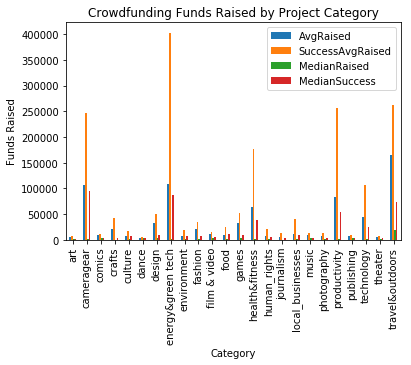

<Figure size 43200x21600 with 0 Axes>

In [22]:
# Compare the money raised by succesfull projects against all projects in a certain category
money = pd.DataFrame()
grp = merged.groupby(['fullcats'])
sucGrp = suc.groupby(['fullcats'])
money['AvgRaised'] = grp.usd_pledged.agg(np.mean)
money['SuccessAvgRaised'] = sucGrp.usd_pledged.agg(np.mean)
money['MedianRaised'] = grp.usd_pledged.agg(np.median)
money['MedianSuccess'] = sucGrp.usd_pledged.agg(np.median)
#money.reset_index(inplace = True)

ax = money.plot(kind = 'bar', title='Crowdfunding Funds Raised by Project Category')
ax.set_xlabel("Category")
ax.set_ylabel("Funds Raised")
plt.figure(figsize=(600,300))


# Comparing pledge goals

The same skew shows up in the fundraising goals for each project, there seems to be a few projects that have very high funding goals.

What's interesting here is that most projects have significantly lower funding goals than the top projects. It's difficult to see, but it also seems there's a relatively small difference in the median funding goals between successful projects and all projects

<Figure size 43200x21600 with 0 Axes>

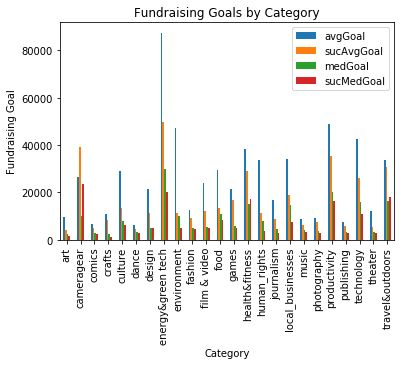

<Figure size 43200x21600 with 0 Axes>

In [23]:
# Delete old dataframes to reduce working memory
del money

# Compare the funding goals for successful projects in each category vs. the funding goals of all projects
goal = pd.DataFrame()
goal['avgGoal'] = grp.goal.agg(np.mean)
goal['sucAvgGoal'] = sucGrp.goal.agg(np.mean)
goal['medGoal'] = grp.goal.agg(np.median)
goal['sucMedGoal'] = sucGrp.goal.agg(np.median)

plt.close()
ax = goal.plot(kind = 'bar', title='Fundraising Goals by Category')
ax.set_xlabel("Category")
ax.set_ylabel("Fundraising Goal")
plt.figure(figsize=(600,300))

# Rates of Success across Categories

Certain categories have much higher rates of success than others.

Comics, publishing, dance, music, and theater all have success rates of 70% or more

An interesting point is that these categories are tied to an individual creator, that have a dedicated fanbase they can draw from

Additionally, projects that require a good to be produced (ie technology products, health and fitness equipment, productivity tools) generally score lower

There's no binding rule for Kickstarter or indiegogo projects to produce the final product, all they require is that creators make a best faith effort. Since there's some inherent risks to these products being produced, it seems like consumers may be weighing that in their backing decisions

<Figure size 43200x21600 with 0 Axes>

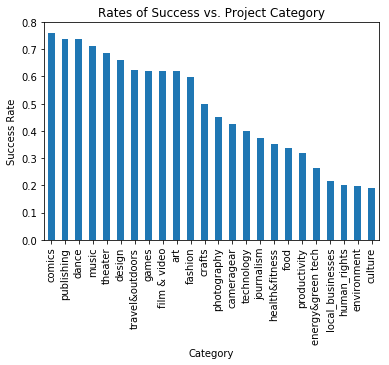

<Figure size 43200x21600 with 0 Axes>

In [24]:
del goal

plt.close()
catCounts = pd.DataFrame()
catCountAll = merged.groupby('fullcats').count()
catCountSuc = suc.groupby('fullcats').count()
catCounts['total_counts'] = catCountAll['source']
catCounts['success_counts'] = catCountSuc['source']
catCounts['successRate'] =  catCounts['success_counts']/catCounts['total_counts']
catCounts = catCounts.sort_values(by = ['successRate'], axis = 0, ascending = False)

ax = catCounts.successRate.plot(kind = 'bar', title='Rates of Success vs. Project Category')
ax.set_xlabel("Category")
ax.set_ylabel("Success Rate")
plt.figure(figsize=(600,300))

## Funding success across categories

The most popular categories generally have the lowest success rates, while things like comics, design photography, and games seem to perform better than average.

These categories would likely typically have fanbases that closely follow the creators. Due to this, they have a reliable audience to draw from when try to source funds for their campaigns

<Figure size 43200x21600 with 0 Axes>

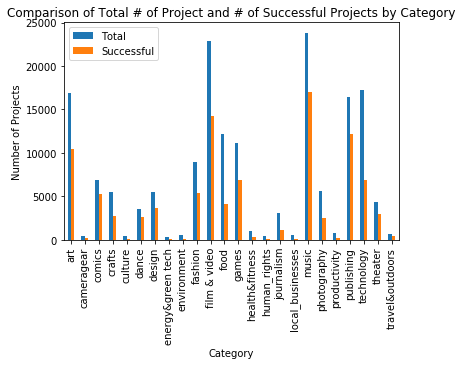

<Figure size 43200x21600 with 0 Axes>

In [25]:
# Look at the number of successfully funded projects in each category vs. the total number of projects
del catCounts

counts = pd.DataFrame()
counts['Total'] = grp.size()
counts['Successful'] = sucGrp.size()

plt.close()
ax = counts.plot(kind = 'bar', title='Comparison of Total # of Project and # of Successful Projects by Category')
ax.set_xlabel("Category")
ax.set_ylabel("Number of Projects")
plt.figure(figsize=(600,300))

## Success rate of projects above a certain amount raised

Because of the large differences between the average funds raised and the median funds raised, it seems like there would be a large number of projects that raise hardly any money at all. 

Let's take a closer look project success rate versus the amount of money raised

Text(0.5, 1.0, 'Funding Goals and Success Rates')

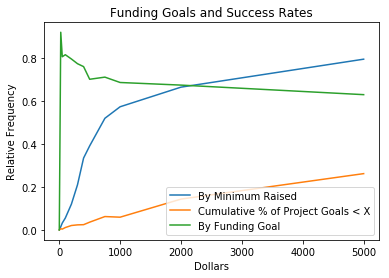

In [26]:
del counts

minRaised = [1, 25, 50, 100, 200, 300, 400, 500, 750, 1000, 2000, 5000]
lowGoals = [1, 25, 50, 100, 200, 300, 400, 500, 750, 1000, 2000, 5000]
succRate = []
goalRate = []
lowGoalSuccess = []
for raised in range(len(minRaised)):
    gotMoney = merged[(merged['usd_pledged'] >= minRaised[raised - 1]) & (merged['usd_pledged'] <= minRaised[raised])]
    gotMoneySuccess = gotMoney[(gotMoney['state'] == 'successful') | (gotMoney['state'] == 'finished')]
    if len(gotMoney) == 0:
        tempRate = 0
    else:
        tempRate = len(gotMoneySuccess) / len(gotMoney)
    succRate.append(tempRate)

for goals in range(len(lowGoals)):
    goalFilter = merged[(merged['goal'] <= lowGoals[goals]) & (merged['goal'] >= lowGoals[goals - 1])]
    lowSuccess = goalFilter[(goalFilter['state'] == 'successful') | (goalFilter['state'] == 'finished')]
    if len(lowSuccess) == 0:
        tempLowSuccess = 0
    else:
        tempLowSuccess = len(lowSuccess) / len(goalFilter)
    tempGoals = len(goalFilter) / len(merged)
    goalRate.append(tempGoals)
    lowGoalSuccess.append(tempLowSuccess)
    
graph = pd.DataFrame({'Dollars' : minRaised,
                     'Minimum_Raised' : succRate,
                     '%_of_Projects' : goalRate,
                     'Success_by_Goal' : lowGoalSuccess})
x = graph['Dollars']
y1 = graph['Minimum_Raised']
y2 = graph['%_of_Projects']
y3 = graph['Success_by_Goal']

plt.close()
plt.plot(x, y1, x, y2, x, y3)
plt.legend(('By Minimum Raised', 'Cumulative % of Project Goals < X', 'By Funding Goal'),
           loc='lower right')
plt.xlabel('Dollars')
plt.ylabel('Relative Frequency')
plt.title('Funding Goals and Success Rates')


## Funding Goals, Minimum Amount Raised, and Success Rates

In the plot above:
'By Minimum Raised' Shows relative frequency of success in projects that raised at least the amounts on the x axis

'Cumulative % of Project Goals' shows the % of projects that have funding goals less than the amounts on the x axis

'By Funding Goal' shows relative frequency of successful projects that have goals lower than amounts on the x axis

While a small % of projects have funding goals less than $1,000, projects that raised up to that amount have an outsized chance of meeting their funding goal. 

This idea seems to stress the importance of finding ambitious "first movers" from the general public to pledge support to projects and share with their friends. This supports the idea that project categories which have fanbases that closely follow project creators have a much better chance at reaching their funding goals. 

### Time between Project Creation and Project Launch

Kickstarter allows creators to create a landing page for their projects before the project is officially launched. This time is for creators to raise awareness about the funding campaign, field questions from potential donors and tweak the campaign before making it live

There's a clear relationship showing that a delay of between 20 and 30 days gives the most benefit 

Text(0.5, 1.0, 'Success Rates vs. Number of Days between Launch and Creation')

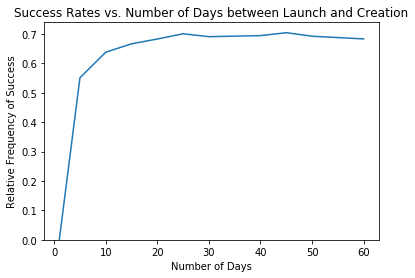

In [27]:
del gotMoney
del gotMoneySuccess
del goalFilter
del lowSuccess
del graph

# Plot the delta between launch and creation date vs. success rate
# Plot the campaign length against success rate
launchCreate = [1, 5, 10, 15, 20, 25, 30, 40, 45, 50, 60]
launchSuccess = []
for i in range(len(launchCreate)):
    longTemp = merged[(merged['creLauDelta'] <= launchCreate[i]) & (merged['creLauDelta'] >= launchCreate[i - 1])]
    longTempSuccess = longTemp[(longTemp['state'] == 'successful') | (longTemp['state'] == 'finished')]
    if len(longTemp) == 0:
        tempRate = 0
    else:
        tempRate = len(longTempSuccess) / len(longTemp)
    launchSuccess.append(tempRate)

graph = pd.DataFrame({'creLauDelta' : launchCreate,
                     'Success_by_Delta' : launchSuccess})
x = graph['creLauDelta']
y1 = graph['Success_by_Delta']

plt.close()
plt.plot(x, y1)
plt.ylim(bottom=0)
plt.xlabel('Number of Days')
plt.ylabel('Relative Frequency of Success')
plt.title('Success Rates vs. Number of Days between Launch and Creation')

## The Importance of Creators in Project Funding Success

In the previous section, there seemed to be a relationship between categories that have dedicated fanbases and an increaesd success rate in reaching funding goals.

To further explore that relationship, make some comparisons grouping projects by the number of other projects a certain creator has launched

Count the number of projects that a certain creator ID has launched, and then add that as a column to the dataframe

In [28]:
creaGroup = pd.DataFrame()
creators = pd.DataFrame()

plt.close()
# Group all projects by creator id and then merge that into the dataframe
creaGroup = merged.groupby('creator').count()
grouped = creaGroup.sort_values(by = ['backers_count'])
grouped = grouped.reset_index()
creators['creator'] = grouped['creator']
creators['no_projects'] = grouped['backers_count']
creators.head()
merged = merged.merge(creators, how = 'left', on = 'creator')

### Relationship between number of projects launched and success rate

There's a small subset of creators that have launched multiple projects. From the chart below, there's an increased rate of success as the number of projects launched by a particular creator increases. Note that this plot is shown by total number of projects, and does not consider the order in which projects were launched by a particular creator

Text(0.5, 1.0, 'Number of Creator Projects and Success Rate')

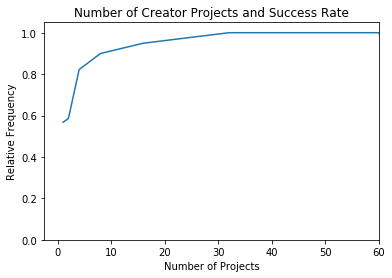

In [29]:
noProjects = [1, 2, 4, 8, 16, 32, 60, 72]
suc = merged[(merged['state'] == ('successful')) | (merged['state'] == ('finished'))]
multi = []
for i in noProjects:
    tempProj = merged[(merged['no_projects'] <= (i)) & (merged['no_projects'] >= (i - 1))]
    tempSucProj = suc[(suc['no_projects'] <= (i)) & (suc['no_projects'] >= (i - 1))]
    if len(tempProj) != 0:
        sucRate = len(tempSucProj) / len(tempProj)
    else:
        sucRate = 0
    multi.append(sucRate)

multiGraph = pd.DataFrame()
multiGraph['no_projects'] = noProjects
multiGraph['success_rate'] = multi
               
x = multiGraph['no_projects']
y1 = multiGraph['success_rate']

plt.close()
plt.plot(x, y1)
plt.ylim(bottom=0)
plt.xlim(right=60)
plt.xlabel('Number of Projects')
plt.ylabel('Relative Frequency')
plt.title('Number of Creator Projects and Success Rate')


### Number of projects launched and percent of goal raised

There also seems to be an increase in average % of goal raised as the number of projects increases. Above 15, the sample size for each category drastically decreases (ie the number of creators that launched more than 15 projects is very small. 

<Figure size 43200x21600 with 0 Axes>

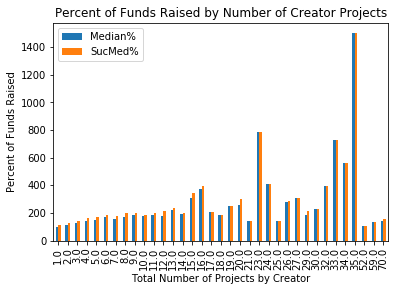

<Figure size 43200x21600 with 0 Axes>

In [30]:
# Compare the money raised by succesfull projects against all projects in a certain category
projects= pd.DataFrame()
proGroup = merged.groupby(['no_projects'])
sucProGrp = suc.groupby(['no_projects'])
#projects['Avg%'] = proGroup.funds_raised_percent.agg(np.mean)
#projects['SucAvg%'] = sucProGrp.funds_raised_percent.agg(np.mean)
projects['Median%'] = proGroup.funds_raised_percent.agg(np.median)
projects['SucMed%'] = sucProGrp.funds_raised_percent.agg(np.median)
#money.reset_index(inplace = True)

plt.close()
ax = projects.plot(kind = 'bar', title='Percent of Funds Raised by Number of Creator Projects')
ax.set_xlabel("Total Number of Projects by Creator")
ax.set_ylabel("Percent of Funds Raised")
plt.figure(figsize=(600,300))

### Number of Projects launched by each creator by category

Visual and performing arts projects are most frequently have creators with a high number of projects. The median number of projects for each creator in each category is 1, so creators with multiple project history is a minority segment of the overall sample population

<Figure size 43200x21600 with 0 Axes>

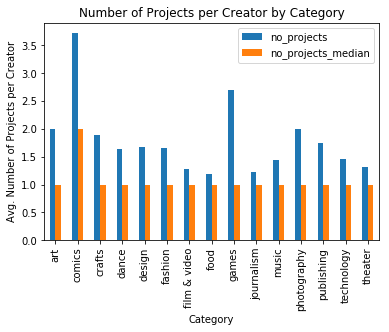

<Figure size 43200x21600 with 0 Axes>

In [31]:
create = pd.DataFrame()
createGrp = merged.groupby(['fullcats'])
create['no_projects'] = createGrp.no_projects.agg(np.mean)
create['no_projects_median'] = createGrp.no_projects.agg(np.median)
create.dropna(axis = 0, inplace = True)

plt.close()
ax = create.plot(kind = 'bar', title='Number of Projects per Creator by Category')
ax.set_xlabel("Category")
ax.set_ylabel("Avg. Number of Projects per Creator")
plt.figure(figsize=(600,300))

### The total number of projects vs. creators with multiple projects

The next plot shows the number of projects in each category and compares that with the number of projects with creators who have launched multiple proejcts.

It's easy to see in this plot that most creators in this dataset have only launched one project

<Figure size 43200x21600 with 0 Axes>

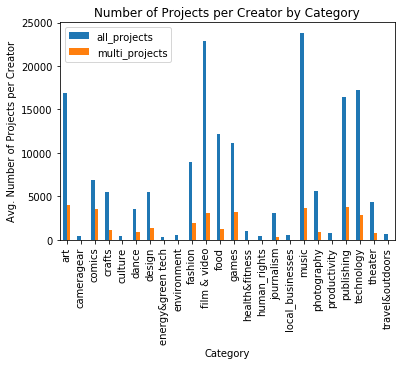

<Figure size 43200x21600 with 0 Axes>

In [32]:
createNumber = pd.DataFrame()
multi = merged[merged['no_projects'] > 1]
createGrp = merged.groupby(['fullcats'])
multiGrp = multi.groupby(['fullcats'])
createNumber['all_projects'] = createGrp.no_projects.size()
createNumber['multi_projects'] = multiGrp.no_projects.size()
createNumber.dropna(axis = 0, inplace = True)

plt.close()
ax = createNumber.plot(kind = 'bar', title='Number of Projects per Creator by Category')
ax.set_xlabel("Category")
ax.set_ylabel("Avg. Number of Projects per Creator")
plt.figure(figsize=(600,300))

### % of Goal Raised versus # of Projects by Creator

Do creators who launch more projects raise more as a % of their goal? 

The next plot seems to show a relationship on Kickstarter. As the number of projects by a single creator increases, the % of goal raised goes up. 

The pearson correlation coefficient shows a weak correlation between the two variables though

Correlation coefficients:
[[1.         0.23371984]
 [0.23371984 1.        ]]


Text(0.5, 1.0, '% of Goal Raised and Number of Projects by Creator')

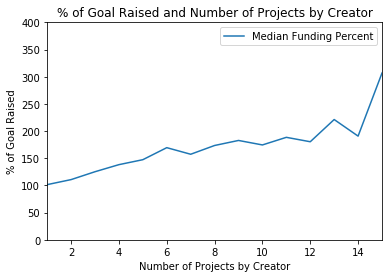

In [33]:
createNoProjects = pd.DataFrame()
noProjects = merged.groupby(['no_projects'])
createNoProjects['funding_percent_avg'] = noProjects.funds_raised_percent.agg(np.mean)
createNoProjects['funding_percent_med'] = noProjects.funds_raised_percent.agg(np.median)
createNoProjects['staLauDelta_avg'] = noProjects.staLauDelta.agg(np.mean)
createNoProjects['staLauDelta_med'] = noProjects.staLauDelta.agg(np.median)
createNoProjects.reset_index(inplace = True)

x = createNoProjects['no_projects']
y1 = createNoProjects['funding_percent_avg'] = noProjects.funds_raised_percent.agg(np.mean)
y2 = createNoProjects['funding_percent_med'] = noProjects.funds_raised_percent.agg(np.median)

coef = np.corrcoef(x, y2)
print('Correlation coefficients:')
print(coef)
plt.close()
plt.plot(x,y2)
plt.legend(('Median Funding Percent', 'Median Funding Percent'), loc='upper right')
plt.xlabel('Number of Projects by Creator')
plt.ylabel('% of Goal Raised')
plt.ylim(bottom=0)
plt.ylim(top = 400)
plt.xlim(right=15)
plt.xlim(left=1)
plt.title('% of Goal Raised and Number of Projects by Creator')

### Dollars Raised and # of Projects by Creator

Do more prolific creators raise more money in total? There seems to be a slightly negative trend in the chart, and the correlation co-efficient is at -0.5.

Creators that launch more projects probably have lower funding goals overeall, as they're more likely to fund a project in sections, or have projects with smaller commitment levels

Correlation coefficients:
[[ 1.         -0.52067273]
 [-0.52067273  1.        ]]


Text(0.5, 1.0, 'Dollars Raised and Number of Projects by Creator')

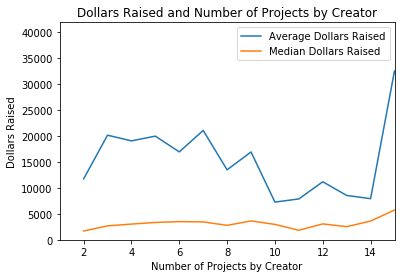

In [34]:
createNoProjects['usd_pledged_avg'] = noProjects.usd_pledged.agg(np.mean)
createNoProjects['usd_pledged_med'] = noProjects.usd_pledged.agg(np.median)
createNoProjects.dropna(axis = 0, inplace = True)

x = createNoProjects['no_projects']
y1 = createNoProjects['usd_pledged_avg']
y2 = createNoProjects['usd_pledged_med'] 

print('Correlation coefficients:')
coef = np.corrcoef(x, y1)
print(coef)

plt.close()
plt.plot(x,y1,x,y2)
plt.legend(('Average Dollars Raised', 'Median Dollars Raised'), loc='upper right')
plt.xlabel('Number of Projects by Creator')
plt.ylabel('Dollars Raised')
plt.ylim(bottom=0)
plt.xlim(right=15)
plt.xlim(left=1)
plt.title('Dollars Raised and Number of Projects by Creator')

### Creator # of Projects and time to reach funding goal

Do creators with more projects reach their funding goals faster? The correlation coefficient here is -0.74, which shows fairly strong evidence that prolific creators do indeed reach their funding goals faster

Correlation coefficients:
[[ 1.         -0.74393574]
 [-0.74393574  1.        ]]


Text(0.5, 1.0, 'Days to Goal and Number of Projects by Creator')

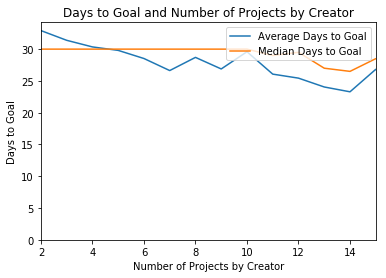

In [35]:
createNoProjects['staLauDelta_avg'] = noProjects.staLauDelta.agg(np.mean)
createNoProjects['staLauDelta_med'] = noProjects.staLauDelta.agg(np.median)

x = createNoProjects['no_projects']
y1 = createNoProjects['staLauDelta_avg']
y2 = createNoProjects['staLauDelta_med']

coef = np.corrcoef(x, y2)
print('Correlation coefficients:')
print(coef)

plt.close()
plt.plot(x,y1,x,y2)
plt.legend(('Average Days to Goal', 'Median Days to Goal'), loc='upper right')
plt.xlabel('Number of Projects by Creator')
plt.ylabel('Days to Goal')
plt.ylim(bottom=0)
plt.xlim(left=2)
plt.xlim(right=15)
#plt.ylim(ymax = 2000)
plt.title('Days to Goal and Number of Projects by Creator')

### Limiting the Results shown for Number of Projects by Creator

Above 14 projects per creator, the number of unique sample points drops off sharply to just a few creators. Rather than view results for sample sizes of 1 or 2, the above graphics were limited to creators that made 15 projects or fewer to show a better representation of the population

In [36]:
merged['no_projects'].value_counts()

1.0     120551
2.0      17190
3.0       5724
4.0       2744
5.0       1730
6.0       1200
7.0        700
8.0        448
11.0       374
10.0       370
9.0        360
12.0       264
13.0       182
17.0       153
14.0       140
16.0       112
18.0       108
15.0       105
26.0       104
19.0        95
20.0        80
25.0        75
70.0        70
32.0        64
59.0        59
52.0        52
23.0        46
35.0        35
34.0        34
33.0        33
30.0        30
29.0        29
27.0        27
24.0        24
21.0        21
Name: no_projects, dtype: int64

### Speed of Reaching goal and % of funds raised

Do projects that reach their goals more quickly raise more money? There's a slightly negative correlation here

Correlation coefficients:
[[ 1.         -0.32191062]
 [-0.32191062  1.        ]]


Text(0.5, 1.0, '% of Goal Raised and Days to Reach Goal')

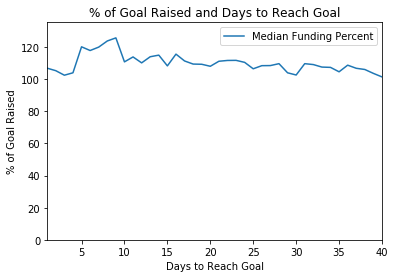

In [37]:
fundRate = pd.DataFrame()
rateProjects = merged.groupby(['staLauDelta'])
fundRate['funding_percent_avg'] = rateProjects.funds_raised_percent.agg(np.mean)
fundRate['funding_percent_med'] = rateProjects.funds_raised_percent.agg(np.median)

fundRate.reset_index(inplace = True)

x = fundRate['staLauDelta']
y2 = fundRate['funding_percent_med']

coef = np.corrcoef(x, y2)
print('Correlation coefficients:')
print(coef)

plt.close()
plt.plot(x,y2)
plt.legend(('Median Funding Percent', 'Median Funding Percent'), loc='upper right')
plt.xlabel('Days to Reach Goal')
plt.ylabel('% of Goal Raised')
plt.ylim(bottom=0)

plt.xlim(right=40)
plt.xlim(left=1)
plt.title('% of Goal Raised and Days to Reach Goal')

### Speed to reach goal and funds raised (In dollars) 

Projects that reach their goals faster should generally raise more as a % of their goal, so the last plot make sense. But how much of this is due to the size of the goal? 

Taking the last plot in consideration with the one below, it seems that projects with large funding goals take longer to reach that goal. This partially explains why projects that take more days to reach that goal still raise more money


Correlation coefficients:
[[1.         0.30976268]
 [0.30976268 1.        ]]


Text(0.5, 1.0, 'USD Pledged and Days to Reach Goal')

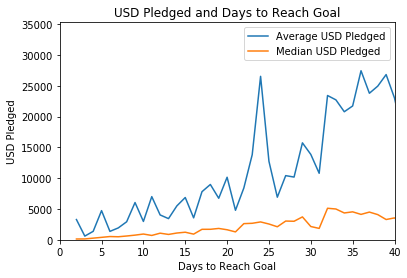

In [38]:
fundRate['usd_pledged_avg'] = rateProjects.usd_pledged.agg(np.mean)
fundRate['usd_pledged_med'] = rateProjects.usd_pledged.agg(np.median)
fundRate.dropna(axis = 0, inplace = True)

x = fundRate['staLauDelta']
y1 = fundRate['usd_pledged_avg']
y2 = fundRate['usd_pledged_med']

coef = np.corrcoef(x, y2)
print('Correlation coefficients:')
print(coef)

plt.close()
plt.plot(x,y1,x,y2)
plt.legend(('Average USD Pledged', 'Median USD Pledged'), loc='upper right')
plt.xlabel('Days to Reach Goal')
plt.ylabel('USD Pledged')
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.xlim(right=40)
plt.title('USD Pledged and Days to Reach Goal')

### Everyone cuts it close

There's an odd abundance of projects that reach their funding goal either very close to, or on the deadline date.

Kickstarter.com has a section of their homepage dedicated to projects whose deadlines are within a certain time limit

We don't have data for funds raised per day, but it seems plausible that the presence on the homepage plus the urgency of a project being close to its goal and end date motivates backers on the fence to contribute

It's also plausible that towards the end of a fundraising campaing, projects push more incentive messages to their target audience

![Kickstarter's "Home Stretch"](https://i.imgur.com/rCG7hj0.png)

### Effects of Staff Picks and Project Spotlights on Campaign Success

As mentioned above, Kickstarter highlights certain projects on their homepage

The dataset that I have includes "Staff Pick" tags, for projects that Kickstarter staff favors

The spotlight tag is a little more ambiguous, but based on the success rate of spotlight projects, it seems like all successfully funded projects are spotlighted at some point

The success rate for staff pick projects is almost 90%, and the rate for spotlighted projects is 100%

In [39]:
staff = merged[(merged['staff_pick'] == True) & (merged['source'] == 'Kickstarter')]
staffSucc = staff[(staff['state'] == 'successful')]
spot = merged[(merged['spotlight'] == True) & (merged['source'] == 'Kickstarter')]
spotSucc = spot[(spot['state'] == 'successful')]
unstaff = merged[(merged['staff_pick'] == False) & (merged['source'] == 'Kickstarter')]
unstaffSucc = unstaff[unstaff['state'] == 'successful']
mergeKick = merged[merged['source'] == 'Kickstarter']

### "Staff Pick" projects and success rate

Recall from above that the average success rate of projects that raised any money at all, and run to completion, succeed about 50% of the time. 

Staff pick projects in this dataset have an almost 90% success rate! 

In [40]:
staffRate = len(staffSucc)/ len(staff)
spotRate = len(spotSucc)/len(spot)

print(staffRate, spotRate)

0.8954918032786885 1.0


### Staff pick project raise more money

When comparing the average and median funds raised by staff picks vs. non-staff picks, it's clear that staff pick projects raise a lot more money 

<Figure size 43200x21600 with 0 Axes>

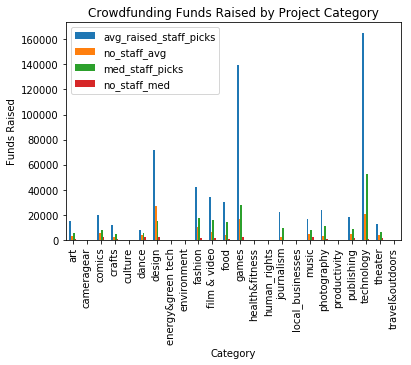

<Figure size 43200x21600 with 0 Axes>

In [41]:
staffMoney = pd.DataFrame()
staffGrp = staff.groupby(['fullcats'])
noStaff = unstaff.groupby(['fullcats'])
staffMoney['avg_raised_staff_picks'] = staffGrp.usd_pledged.agg(np.mean)
staffMoney['no_staff_avg'] = noStaff.usd_pledged.agg(np.mean)
staffMoney['med_staff_picks'] = staffGrp.usd_pledged.agg(np.median)
staffMoney['no_staff_med'] = noStaff.usd_pledged.agg(np.median)

plt.close()
ax = staffMoney.plot(kind = 'bar', title='Crowdfunding Funds Raised by Project Category')
ax.set_xlabel("Category")
ax.set_ylabel("Funds Raised")
plt.figure(figsize=(600,300))

### Size of the staff pick population

In this dataset, around 11% of all projects are labeled as staff picks. However, they account for about 20% of all successful projects on the platform.

In [42]:
unstaff = merged[merged['staff_pick'] == False]
unstaffSucc = unstaff[unstaff['state'] == 'successful']
print('the number of successful projects that were not staff picks is ', len(unstaffSucc))
print('the number of successful projects that are staff picks is ', len(staffSucc))
kickOnly = merged[merged['source'] == 'Kickstarter']
print('the total number of projects is ', len(kickOnly))

the number of successful projects that were not staff picks is  78948
the number of successful projects that are staff picks is  19228
the total number of projects is  153333


### Staff picks are uneven across categories

The number of staff picks aren't picked in exact proportion to the number of projects in each category, but it's close. The correlation coefficient here is around 0.97

Correlation coefficients:
[[1.         0.91547717]
 [0.91547717 1.        ]]


<Figure size 43200x21600 with 0 Axes>

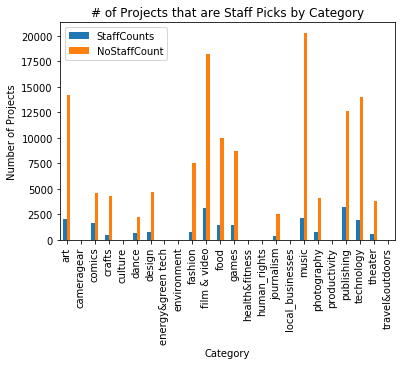

<Figure size 43200x21600 with 0 Axes>

In [43]:
staffMoney = pd.DataFrame()
staffMoney['StaffCounts'] = staffGrp.size()
staffMoney['NoStaffCount'] = noStaff.size()

x = staffMoney['StaffCounts']
y = staffMoney['NoStaffCount']

coef = np.corrcoef(x, y)
print('Correlation coefficients:')
print(coef)

plt.close()
ax = staffMoney.plot(kind = 'bar', title='# of Projects that are Staff Picks by Category')
ax.set_xlabel("Category")
ax.set_ylabel("Number of Projects")
plt.figure(figsize=(600,300))

### Staff Pick projects account for a large portion of all funds raised on the platform

Despite being 11% of all projects on the platform, staff pick projects account for 45% of all money raised on the platform. In some categories, the proporton of funds raised by staff pick projects account for nearly 60% of all money raised. 

<Figure size 43200x21600 with 0 Axes>

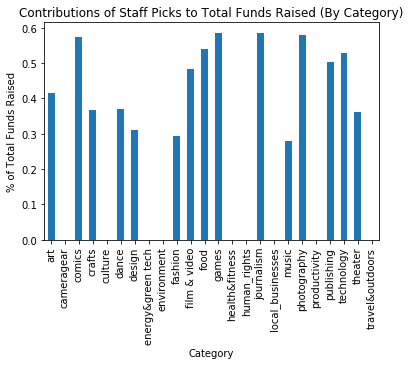

<Figure size 43200x21600 with 0 Axes>

In [44]:
allKick = mergeKick.groupby(['fullcats'])
noStaffCont = allKick.usd_pledged.agg(np.sum)
staffCont = staffGrp.usd_pledged.agg(np.sum)
contributions = pd.DataFrame()
contributions['staff_picks'] = staffCont / noStaffCont
#contributions.dropna(axis = 0, inplace = True)

plt.close()
ax = contributions.plot(kind = 'bar', title='Contributions of Staff Picks to Total Funds Raised (By Category)')
ax.get_legend().remove()
ax.set_xlabel("Category")
ax.set_ylabel("% of Total Funds Raised")
plt.figure(figsize=(600,300))

In [45]:
plt.close()
total = contributions.mean(axis = 0)

print('Kickstarter staff picks accounts for ', total, '% of all funds raised on average')

Kickstarter staff picks accounts for  staff_picks    0.451525
dtype: float64 % of all funds raised on average


### Repeat the staff_picks analysis for Indiegogo projects only

The previous results were only for Kickstarter projects, let's see how Indiegogo compares

In [46]:
indie = original[(original['source'] == 'indiegogo') & (original['fullcats'] != 'theater') & (original['fullcats'] != 'design')]
staff = indie[(indie['staff_pick'] == True)]
staffSucc = staff[(staff['state'] == 'successful')]
unstaff = indie[(indie['staff_pick'] == False)]
unstaffSucc = unstaff[unstaff['state'] == 'successful']

### Indiegogo labels algorithm picked projects as "In Demand"

The success rate on Indiegogo is much lower, around 30%. However, the success rate of algorithm picked projects is 99%!

In [47]:
staffRate = len(staffSucc)/ len(staff)

print(staffRate, spotRate)

0.9910714285714286 1.0


### Comparing Money raised by In Demand projects vs. non In Demand

Indiegogo follows a similar pattern to Kickstarter, projects that are "In Demand" raise much more money than other projects

<Figure size 43200x21600 with 0 Axes>

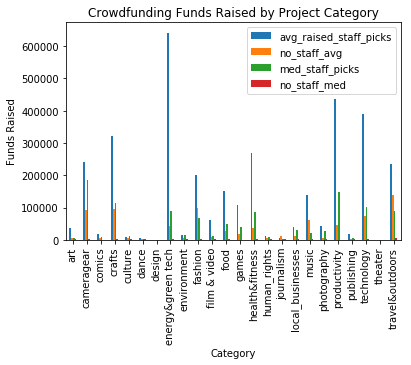

<Figure size 43200x21600 with 0 Axes>

In [48]:
staffMoney = pd.DataFrame()
staffGrp = staff.groupby(['fullcats'])
noStaff = unstaff.groupby(['fullcats'])
staffMoney['avg_raised_staff_picks'] = staffGrp.usd_pledged.agg(np.mean)
staffMoney['no_staff_avg'] = noStaff.usd_pledged.agg(np.mean)
staffMoney['med_staff_picks'] = staffGrp.usd_pledged.agg(np.median)
staffMoney['no_staff_med'] = noStaff.usd_pledged.agg(np.median)

plt.close()
ax = staffMoney.plot(kind = 'bar', title='Crowdfunding Funds Raised by Project Category')
ax.set_xlabel("Category")
ax.set_ylabel("Funds Raised")
plt.figure(figsize=(600,300))

### Proportion of In Demand Projects

Only 9% of projects are selected as In Demand by Indiegogo, but they account for 26% of all successful projects on the platform


In [49]:
unstaff = indie[indie['staff_pick'] == False]
unstaffSucc = unstaff[unstaff['state'] == 'successful']
print('the number of successful projects that were not staff picks is ', len(unstaffSucc))
print('the number of successful projects that are staff picks is ', len(staffSucc))
print('the total number of projects is ', len(indie))

the number of successful projects that were not staff picks is  4005
the number of successful projects that are staff picks is  1443
the total number of projects is  15879


### The proportions of In Demand projects by category

In Demand projects on Indiegogo don't follow the total number of projects in each category as closely as the kickstarter data did. This may be due to an abundance of creators in one category that's not necessarily popular with backers. It could also be due to a selection bias in the search results provided by Indiegogo

Correlation coefficients:
[[1.        0.5716733]
 [0.5716733 1.       ]]


<Figure size 43200x21600 with 0 Axes>

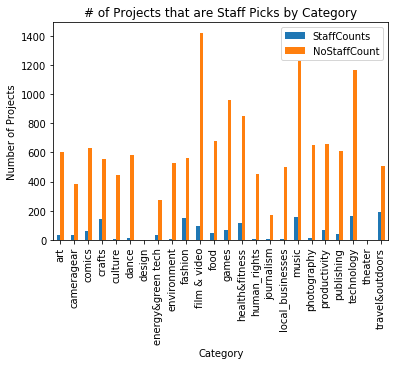

<Figure size 43200x21600 with 0 Axes>

In [50]:
staffMoney = pd.DataFrame()

staffMoney['StaffCounts'] = staffGrp.size()
staffMoney['NoStaffCount'] = noStaff.size()

x = staffMoney['StaffCounts']
y = staffMoney['NoStaffCount']

coef = np.corrcoef(x, y)
print('Correlation coefficients:')
print(coef)

plt.close()
ax = staffMoney.plot(kind = 'bar', title='# of Projects that are Staff Picks by Category')
ax.set_xlabel("Category")
ax.set_ylabel("Number of Projects")
plt.figure(figsize=(600,300))

### In demand funds raised vs. all funds raised 

Interestingly, although In Demand projects account for a larger portion of the successful projects on Inidiegogo, it only accounts for 25% of the money raised on the platform, compared with 45% for Kickstarter

<Figure size 43200x21600 with 0 Axes>

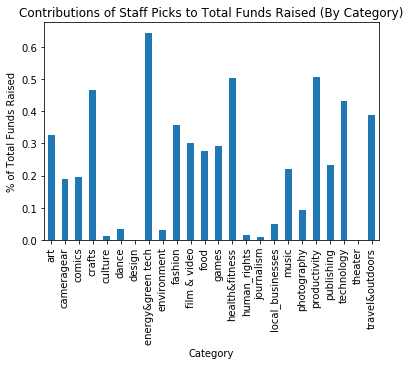

<Figure size 43200x21600 with 0 Axes>

In [51]:
allKick = indie.groupby(['fullcats'])
noStaffCont = allKick.usd_pledged.agg(np.sum)
staffCont = staffGrp.usd_pledged.agg(np.sum)
contributions = pd.DataFrame()
contributions['staff_picks'] = staffCont / noStaffCont

plt.close()
ax = contributions.plot(kind = 'bar', title='Contributions of Staff Picks to Total Funds Raised (By Category)')
ax.get_legend().remove()
ax.set_xlabel("Category")
ax.set_ylabel("% of Total Funds Raised")
plt.figure(figsize=(600,300))

In [52]:
plt.close()
total = contributions.mean(axis = 0)
print('Indiegogo staff picks accounts for ', total, '% of all funds raised on average')

Indiegogo staff picks accounts for  staff_picks    0.253684
dtype: float64 % of all funds raised on average


### Distribution of % of Goal Raised

Finally, look at the distrbution of % of goal raised. From the histogram, it looks like most projects that are successful barely reach their funding goal. 

Text(0.5, 1.0, 'Distribution of % of Goal Raised')

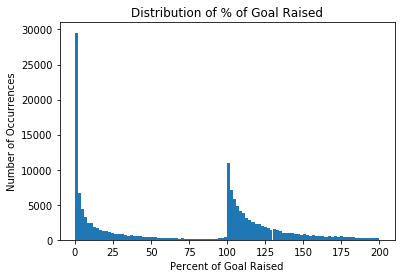

In [53]:
x = merged[(merged['funds_raised_percent'] < 200)]
y = x['funds_raised_percent']

plt.close()
plt.hist(y, bins = 100)
plt.xlabel('Percent of Goal Raised')
plt.ylabel('Number of Occurrences')
plt.title('Distribution of % of Goal Raised')

### When do most projects reach their goal?

If most projects barely reach their goal, how long does it take to get there? It seems like the majority of projects that are successful reach their goal in the final days of the campaign

/Users/chrismay/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/chrismay/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'Distribution of # of Days to Reach Goal')

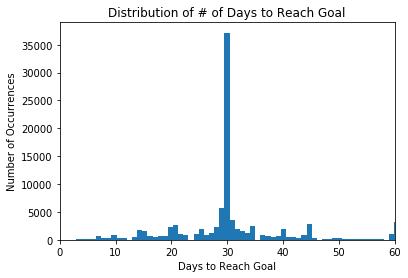

In [54]:
x = merged[merged['state'] == 'successful']
y = x['staLauDelta']

plt.close()
plt.hist(y, bins = 100)
plt.xlabel('Days to Reach Goal')
plt.ylabel('Number of Occurrences')
plt.xlim(left=0)
plt.xlim(right=60)
plt.title('Distribution of # of Days to Reach Goal')

# Modeling

From the EDA, it seems that selection by the homepage algorithm on each platform plays a large part in whether or not a project will reach it's funding goal.

To measure the impact of algorithm selection, I've trained a logistic regression model to predict whether or not projects will reach their goals. Then I'll look at the weighting coefficients for each variable and compare the weights given to each platforms selection algorithm

In [55]:
from sklearn import preprocessing as pre
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV

In [56]:
mergeKick.columns

Index(['backers_count', 'blurb', 'country', 'created_at', 'creator',
       'currency', 'deadline', 'fx_rate', 'goal', 'id', 'launched_at', 'name',
       'slug', 'spotlight', 'staff_pick', 'state', 'state_changed_at', 'urls',
       'usd_pledged', 'fullcats', 'city', 'creLauDelta', 'lauDeadDelta',
       'staLauDelta', 'source', 'funds_raised_percent', 'launch_date', 'Date',
       'Rank', 'no_projects'],
      dtype='object')

### Feature selection

A lot of the column data from the datasets are related to whether or not a project was successful. Careful variable selection is important to prevent data leakage into the final model. I'm using all variables that are available when the project is launched to make the predictions, plus the external Alexa ranking data at the time of project launch

In [84]:
# Make a new dataframe with only the columns that we'll use for modeling
kickModel = pd.DataFrame()
kickModel['country'] = mergeKick['country']
kickModel['goal'] = mergeKick['goal']
kickModel['id'] = mergeKick['id']
kickModel['launched_at'] = mergeKick['launched_at']
kickModel['staff_pick'] = mergeKick['staff_pick']
kickModel['alexa_rank'] = mergeKick['Rank']
kickModel['creator_projects'] = mergeKick['no_projects']
kickModel['state'] = mergeKick['state']
kickModel['creLauDelta'] = mergeKick['creLauDelta']
kickModel['category'] = mergeKick['fullcats']

kickModel['staff_pick'] = kickModel.apply(lambda x: int(x['staff_pick'] == True), axis = 1)
kickModel['state'] = kickModel.apply(lambda x: int(x['state'] == 'successful'), axis = 1)
kickModel.head()

,country,goal,id,launched_at,staff_pick,alexa_rank,creator_projects,state,creLauDelta,category
0,US,5000,1203770415,1491540705,0,548.0,1.0,0,19.0,film & video
1,MX,3382,878861613,1509893074,0,528.0,1.0,1,16.0,film & video
2,NZ,6850,917345297,1427147079,0,NaN,1.0,1,7.0,theater
3,US,40000,1702164653,1487077744,1,589.0,1.0,1,49.0,comics
4,US,2000,1042930184,1507662001,0,503.0,1.0,1,16.0,games


### Make dummy variables

Make dummies for project category and country codes rather than keeping them as text data

In [85]:
dummies1 = pd.get_dummies(kickModel['category'], columns = 'category')
dummies2 = pd.get_dummies(kickModel['country'], columns = 'country')
kickModel = pd.concat([kickModel, dummies1], axis = 1)
kickModel = pd.concat([kickModel, dummies2], axis = 1)
kickModel.drop(labels = ['category', 'country'], axis = 1, inplace = True)
kickModel.head()

,goal,id,launched_at,staff_pick,alexa_rank,creator_projects,state,creLauDelta,art,cameragear,...,VE,VI,VN,VU,WS,XK,YE,ZA,ZM,ZW
0,5000,1203770415,1491540705,0,548.0,1.0,0,19.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3382,878861613,1509893074,0,528.0,1.0,1,16.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6850,917345297,1427147079,0,NaN,1.0,1,7.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40000,1702164653,1487077744,1,589.0,1.0,1,49.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2000,1042930184,1507662001,0,503.0,1.0,1,16.0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Imputing Alexa data

The Alexa ranking data I have only goes back for the last three years, so fill in any missing rows with the average traffic ranking.

While the site rankings showed a slightly cyclical pattern, I'm using the average of all readings since it has stayed relatively consistent over time

In [86]:
np.mean(kickModel['alexa_rank'])

543.9685947216519

In [87]:
kickModel = kickModel.fillna(value = np.mean(kickModel['alexa_rank']), axis = 0)

### Train/Test split and training the model

There's a large range of numerical data in the dataset which can throw off the model. I'm using the standard scaler function to scale all of the numerical columns to values between 0 and 1. The values assigned here are relative to the full range of each particular variable (ie, the minimum in a column is set to 0 and the maximum is set to 1) 

I'm holding 30% of the data to test the model trained here. 

In [88]:
X = kickModel.loc[:, kickModel.columns != 'state']
y = kickModel.loc[:, kickModel.columns == 'state']

#Use a MinMax scaler to standardize features
scaler = MinMaxScaler(feature_range = (0,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

logreg.fit(X_train, y_train)

/Users/chrismay/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, uint32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/chrismay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chrismay/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

### Results 

The out of sample accuracy for the model was 0.71, which is pretty weak. However, the ROC plot showed a low number of false positives versus correct positives which is good. Overall, the model seemed to favor predicting success where projects actually failed. 

In [89]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.71


In [90]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 8577,  9326],
       [ 3819, 24278]])

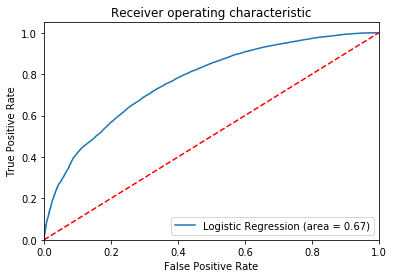

In [91]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [94]:
X.head()

,goal,id,launched_at,staff_pick,alexa_rank,creator_projects,creLauDelta,art,cameragear,comics,...,VE,VI,VN,VU,WS,XK,YE,ZA,ZM,ZW
0,5000,1203770415,1491540705,0,548.000000,1.0,19.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3382,878861613,1509893074,0,528.000000,1.0,16.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6850,917345297,1427147079,0,543.968595,1.0,7.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40000,1702164653,1487077744,1,589.000000,1.0,49.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,2000,1042930184,1507662001,0,503.000000,1.0,16.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Model weight coefficients

Project funding goal, number of projects by creator, and whether it was a staff pick were given the greatest weights in the model (in that order). 

Higher funding goals were a lot less likely to be predicted as successful by the model, while creators with a high number of projects were more likely to be predicted as successful. 

Interestingly, despite the high % of funds raised by staff pick projects on Kickstarter, it was given less weight in the prediction model. This is probably due to the fact that it's a really small portion of the sample size.

In [97]:
# Print the model weights for various variables
print('The model weighting for funding goal is ', logreg.coef_[0][0])
print('The model weighting for staff pick is ', logreg.coef_[0][3])
print('The model weighting for Alexa ranking is ', logreg.coef_[0][4])
print('The model weighting for number of projects by Creator is ', logreg.coef_[0][5])
print('The model weighting for time between creation and launch is  ', logreg.coef_[0][6])

The model weighting for funding goal is  -24.18635068239897
The model weighting for staff pick is  2.1287965248284806
The model weighting for Alexa ranking is  0.9341136715107223
The model weighting for number of projects by Creator is  16.270011121829683
The model weighting for time between creation and launch is   1.0429854993107786


### Training the model on the Indiegogo dataset

The same restriction for feature selection applies to the indiegogo data as well. 

In [66]:
# Make a new dataframe with only the columns that we'll use for modeling
indieModel = pd.DataFrame()
indieModel['goal'] = indie['goal']
indieModel['id'] = indie['id']
indieModel['launched_at'] = indie['launched_at']
indieModel['rank'] = indie['Rank']
indieModel['staff_pick'] = indie['staff_pick']
indieModel['state'] = indie['state']
indieModel['category'] = indie['fullcats']

indieModel['rank'].fillna(value = np.mean(indieModel['rank']), axis = 0, inplace = True)
indieModel['staff_pick'] = indieModel.apply(lambda x: int(x['staff_pick'] == True), axis = 1)
indieModel['state'] = indieModel.apply(lambda x: int(x['state'] == 'successful'), axis = 1)
indieModel.head()

,goal,id,launched_at,rank,staff_pick,state,category
181302,10041,2397370,1531627200,2078.000000,1,1,crafts
181303,37043,2393782,1531195200,2104.000000,1,1,health&fitness
181304,3000,413752,1369800000,1826.354635,0,1,comics
181305,28937,2276585,1513141200,1872.000000,0,1,crafts
181306,2641,2352230,1521086400,2179.000000,1,1,crafts


### Run the Staff_Picks Analysis on the IndieGoGo data to compare with Kickstarter

Get dummies the same way as the kickstarter data. Since there's no country data available here, leave that out of the analysis

I'm using standard scaler again here to normalize numerical data to the same range

In [67]:
dummies1 = pd.get_dummies(indieModel['category'], columns = 'category')
indieModel = pd.concat([indieModel, dummies1], axis = 1)
indieModel.drop(labels = ['category'], axis = 1, inplace = True)
indieModel.head()

,goal,id,launched_at,rank,staff_pick,state,art,cameragear,comics,crafts,...,human_rights,journalism,local_businesses,music,photography,productivity,publishing,technology,theater,travel&outdoors
181302,10041,2397370,1531627200,2078.000000,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
181303,37043,2393782,1531195200,2104.000000,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
181304,3000,413752,1369800000,1826.354635,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
181305,28937,2276585,1513141200,1872.000000,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
181306,2641,2352230,1521086400,2179.000000,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [98]:
X = indieModel.loc[:, indieModel.columns != 'state']
y = indieModel.loc[:, indieModel.columns == 'state']

#Use a MinMax scaler to standardize features
scaler = MinMaxScaler(feature_range = (0,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

logreg.fit(X_train, y_train)

/Users/chrismay/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, uint32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/chrismay/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chrismay/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

### Results 

The prediction accuracy of the Indiegogo data was similar to the Kickstarter data, this time 0.76. This time the model favored failures over successes, probably due to the lower number of successful projects on Indiegogo. 

In [99]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.76


In [100]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[3105,   65],
       [1097,  497]])

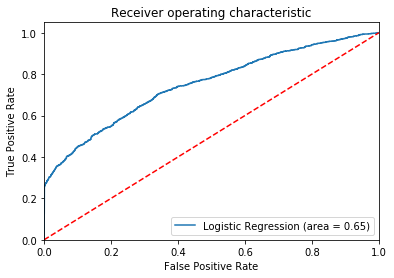

In [71]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [101]:
X.head()

,goal,id,launched_at,rank,staff_pick,art,cameragear,comics,crafts,culture,...,human_rights,journalism,local_businesses,music,photography,productivity,publishing,technology,theater,travel&outdoors
181302,10041,2397370,1531627200,2078.000000,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
181303,37043,2393782,1531195200,2104.000000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
181304,3000,413752,1369800000,1826.354635,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
181305,28937,2276585,1513141200,1872.000000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
181306,2641,2352230,1521086400,2179.000000,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Model weights

For the Indiegogo dataset, the model weights for staff picks was much higher than the Kickstarter dataset. It doesn't seem to be a completely fair comparison though, since there's a lot fewer features available for the Indiegogo dataset. Again, the weighting may be lower than expected due to a relatively small proportion of projects being selected as staff picks

In [102]:
print('The model weighting for funding goal is ', logreg.coef_[0][0])
print('The model weighting for staff pick is ', logreg.coef_[0][4])
print('The model weighting for Alexa ranking is ', logreg.coef_[0][3])

The model weighting for funding goal is  -2.4070770352420405
The model weighting for staff pick is  5.050530478905081
The model weighting for Alexa ranking is  -0.8009405604524322


# Conclusion

In this analysis, project success seemed more heavily impacted by algorithm selection on the Indiegogo platform. More work is needed to make a stronger argument for this conclusion though. Some possible future work includes:

- Scraping more web data for a more robust analysis
    - The features used to model each dataset aren't the same. Because the same features aren't used, model weights assigned to each variable aren't necessarily consistent across datasets
- Balancing sample frequency with oversampling/undersampling
    - "Staff pick" projects are a relatively small portion of the total dataset, and their representation on the   platforms aren't in the same ratio (11% for Kickstarter, 13% for Indiegogo). Because of this, the model weights analysis may not be an adequate measurement for analyzing the impact of algorithm selection on project success
    
- Revisiting the analysis for % of Goal Raised
    - Running a similar analysis, but with % of goal raised instead. This could give an estimate of how much "lift" is given to projects selected by each platform's algorithm and give a better comparison
    
- ANOVA
    - Additionally, an ANOVA could be run to determine whether algorithm selection has an impact on project funding.

# Appendix A: Data Descriptions

| Columns | Data Type | Description | 
|---|---|---|
|Backers Count| int64 | Total number of individual backers of a project
|Blurb|object| The short description of the project
|Category| list | A list of categories that the project has been tagged under
|Country| string| Two character country code of the campaign’s headquarters
|Created_at|int64| The creation date of the campaign in epoch time
|Creator| string |A list of the creator’s name and their creator ID on Kickstarter.com
|Currency| string| A two character string of the domestic currency of the project
|Deadline| int64|The end date/time of the campaign in epoch time
|Goal| int64|The funding goal of the project in native currency
|Id| int64|The unique project ID
|Launched_at| int64|Launch date of the campaign in epoch time
|Location| string|The main location of the project
|Name| object|The name of the project
|Pledged| int64|Total amount pledged (in the project’s home currency)
|Slug| string|An abbreviated description of the project
|Spotlight|string|True/False categorical variable of whether the project was featured by Kickstarter
|Staff_pick|string|True/False categorical variable of whether the project was a staff pick or not
|State|string|Successful/Failed/Canceled/Active  categorical variable of the projects current status
|State_changed_at| int64|Time/date that the project changed states, in epoch time
|Static_usd_rate| int64|Static conversion rate between home currency and USD
|Urls| string|Various URL’s associated with the project
|Usd_pledged| int64|Total amount pledged, converted to USD

# Appendix B: Previous Work and Citations

[Good Audience](https://blog.goodaudience.com/kickstarter-projects-prediction-of-state-steps-for-a-beginner-analysis-f4630a50b7fe)<br>
•	Runs logistic regression, XGBoost, Random forests, LightGBM and an Ensemble method to try and predict whether a project will be successfully funded or not. Based on the Kaggle dataset (limited to 49k entries). Mainly focused on feature selection

[Towards Data Science](https://towardsdatascience.com/predicting-the-success-of-kickstarter-campaigns-3f4a976419b9)<br>
•	Again predictions on successful funding, based on funding goals, category, rewards levels, and location data. Uses random forests, logistic regression, and kNearest Neighbors

[Bentley University](https://www.bentley.edu/prepared/what-secret-perfect-kickstarter-campaign)<br>
•	Finds length of description and title are important
•	Also the date of the launch important (winter is the best month)
•	Higher average donations, shorter campaign durations

# Appendix C: Datasheet

### Why was the dataset created? (e.g., were there specific tasks in mind, or a specific gap that needed to be filled?) 
Both the Kickstarter and Indiegogo datasets were created by webrobots.io and is currently listed under the “Projects” section of their website. There’s no analysis posted on the website, and no description of why it was created. The website identifies as a “Data as a Service” provider, so it seems this dataset was created as a demo for the type of services they can provide. 

### What (other) tasks could the dataset be used for? Are there obvious tasks for which it should not be used? 
Aside from the original purpose, the dataset can be used for running analyses on projects from the Kickstarter and Indiegogo. Spotting trends or patterns in successful campaigns can be useful for creators interested in increasing their chances of launching a successful project. 

### Has the dataset been used for any tasks already? If so, where are the results so others can compare (e.g., links to published papers)? 
The data from the webrobots.io website has been used for many studies, some examples of papers published using this data are given in Appendix A: Examples of Published Work using the webrobots.io Kickstarter Dataset. 

### Who funded the creation of the dataset? If there is an associated grant, provide the grant number. 
Webrobots.io was backed by Practice Capital in 2014. Practica Capital is a venture capital firm focused on technology companies in Baltic States. Webrobots.io itself is based in Vilnius, Lithuania. The VC firm exited their position in 2016, and the dataset has been continuously maintained since 2015. 

### Any other comments? 

## Dataset Composition
What are the instances? (that is, examples; e.g., documents, images, people, countries) Are there multiple types of instances? (e.g., movies, users, ratings; people, interactions between them; nodes, edges) 
Each instance in this dataset is from an individual project on each website. All of the information in the dataset was taken from the project page of either website. The features of the dataset and a brief description of each entry is provided in Appendix B: Data Description. In its original form, all instances are the same type, and there’s no interactions between variables. 

### Are relationships between instances made explicit in the data (e.g., social network links, user/movie ratings, etc.)? 
Each instance is tagged with a project category and country of origin. Multiple projects can fall under the same category label, and there are many projects that share the same country of origin. 

### How many instances of each type are there? 
In the original dataset, there are 189,000 instances of Kickstarter data, and 15000 instances on Indiegogo data

### What data does each instance consist of? “Raw” data (e.g., unprocessed text or images)? Features/attributes? Is there a label/target associated with instances? If the instances are related to people, are subpopulations identified (e.g., by age, gender, etc.) and what is their distribution?
Each instance is tagged with a unique project ID, which is generated by the platform it came from. The data provided in the dataset is mostly features that describe the project, it’s current status, and progress made towards the funding goal. The number of instances under each project category should be similar in this dataset (since each search result is limited by Kickstarter rules). The true population distribution under each category is unknown. 

### Is everything included or does the data rely on external resources? (e.g., websites, tweets, datasets) If external resources, a) are there guarantees that they will exist, and remain constant, over time; b) is there an official archival version. Are there licenses, fees or rights associated with any of the data? 
Right now, everything is included with the original dataset. As the project moves on, there may be external data merged in with the original dataset. Content submitted to Kickstarter.com when creating a project grants Kickstarter.com with an irrevocable royalty-free license. Essentially, anything submitted to Kickstarter.com or Indiegogo is owned by Kickstarter or Indiegogo. If a creator deletes their account, the project and project information can be requested to be removed, but it’s not guaranteed. 

### Are there recommended data splits or evaluation measures? (e.g., training, development, testing; accuracy/AUC) 
No recommended evaluation procedures have been given for this dataset

### What experiments were initially run on this dataset? Have a summary of those results and, if available, provide the link to a paper with more information here. 
No experiments were initially run on the dataset by the dataset provider

### Any other comments? 

## Data Collection Process
### How was the data collected? (e.g., hardware apparatus/sensor, manual human curation, software program, software interface/API; how were these con- structs/measures/methods validated?) 
The data was collected using web scraping techniques by webrobots.io. Neither Kickstarter nor Indiegogo have a public facing API, so the creators wrote some automated program to do the work. 

### Who was involved in the data collection process? (e.g., students, crowd workers) How were they compensated? (e.g., how much were crowd workers paid?) 
The creators of the dataset aggregated all of the data. Individual project creators contributed their data to the  website, in hopes of raising funds for their personal projects. The dataset doesn’t include any outside information such as comments, or social media interactions from people not directly involved with the projects. 

### Over what time-frame was the data collected? Does the collection time-frame match the creation time-frame? 
The dataset creators have been running a monthly crawl of each page since 2015 

### How was the data associated with each instance acquired? Was the data directly observable (e.g., raw text, movie ratings), reported by subjects (e.g., survey responses), or indirectly inferred/derived from other data (e.g., part of speech tags; model-based guesses for age or language)? If the latter two, were they validated/verified and if so how? 
The data from each instance was directly observed from project pages. 

### Does the dataset contain all possible instances? Or is it, for instance, a sample (not necessarily random) from a larger set of instances? 
Starting in 2015, Kickstarter began limiting search results under each category. As a result, the data provided in this dataset is not the complete population. This project pulls crawl results from multiple years in an attempt to maximize the number of samples included. Indiegogo has similar restrictions. 

### If the dataset is a sample, then what is the population? What was the sampling strategy (e.g., deterministic, probabilistic with specific sampling probabilities)? Is the sample representative of the larger set (e.g., geographic coverage)? If not, why not (e.g., to cover a more diverse range of in- stances)? How does this affect possible uses? 
The algorithm that serves up search results from the pages is unknown. In total, there are 436,999 projects that have been launched on Kickstarter. There are many duplicate entries in the dataset but based on a count of the unique project id’s, the dataset managed to capture around 170000 projects. 

### Is there information missing from the dataset and why? (this does not include intentionally dropped instances; it might include, e.g., redacted text, withheld documents) Is this data missing because it was unavailable? 
Information about the project creators (aside from the creator/group name) is not included in this dataset, likely for privacy reasons. 

### Are there any known errors, sources of noise, or redundancies in the data? 
There are multiple duplicates in the entire dataset due to search results overlapping between search dates. In addition to entries being duplicated at different times, the sub-category search feature was used starting from April 2016. Due to this, multiple projects were returned under different sub-categories. 

### Any other comments? 

## Data Preprocessing
### What preprocessing/cleaning was done? (e.g., discretization or bucketing, tokenization, part-of-speech tagging, SIFT feature extraction, removal of instances, processing of missing values, etc.) 
The original data was in a JSON format, the creators of the dataset split the JSON file into multiple CSV files. Aside from that no other preprocessing or cleaning has been done. The data provided in the dataset is a subset of what’s fully available on the Kickstarter or Indiegogo website. 

### Was the “raw” data saved in addition to the preprocessed/cleaned data? (e.g., to support unanticipated future uses) 
Webrobots.io lists the original JSON files as well as the CSV files used in this project

### Is the preprocessing software available? 
N/A, but the original software used to scrape the website is not available from webrobots as it’s an IP item. 
Does this dataset collection/processing procedure achieve the motivation for creating the dataset stated in the first section of this datasheet? 
The original intention was to demonstrate the abilities of the DaaS company webrobots.io. The creation of the dataset achieves the original purpose. 

### Any other comments? 

## Dataset Distribution
### How is the dataset distributed? (e.g., website, API, etc.; does the data have a DOI; is it archived redundantly?) 
The dataset is available in the projects section of the webrobots.io website. There’s no publicly available redundant archives, but the site likely backs up its data by following some standard best practices. 

### When will the dataset be released/first distributed? (Is there a canonical paper/reference for this dataset?) 
The dataset was first released in April of 2014, it’s been updated monthly since that date. 

### What license (if any) is it distributed under? Are there any copyrights on the data? 
There is no license information available on the webrobots.io website

### Are there any fees or access/export restrictions? Any other comments? 
No restrictions have been noted by the creators of the dataset, and the source data is publicly available.

### Any other comments?

## Dataset Maintenance
### Who is supporting/hosting/maintaining the dataset? How does one contact the owner/curator/manager of the dataset (e.g. email address, or other contact info)? 
There’s a contact section on the webrobots.io website, but no public e-mail address associated with that. 

### Will the dataset be updated? How often and by whom? How will updates/revisions be documented and communicated (e.g., mailing list, GitHub)? Is there an erratum? 
The data is updated monthly by webrobots.io. Updates are posted as new datasets with a timestamp of the upload date/time. There’s no changelog, each version is posted as a new file. 

### If the dataset becomes obsolete how will this be communicated? 
There’s no public information available on how an obsoleting will be communicated. However, the data captures direct observations and so privately maintained files should be valid indefinitely. 

### Is there a repository to link to any/all papers/systems that use this dataset? 
There is no single repository that links all papers using this dataset. The publicly available nature of the dataset makes it difficult to track which papers use this dataset, and which papers use a version provided by another creator.  

### If others want to extend/augment/build on this dataset, is there a mechanism for them to do so? If so, is there a process for tracking/assessing the quality of those contributions. What is the process for communicating/distributing these contributions to users? 
This dataset is not openly available for public contributions.

### Any other comments? 

## Legal and Ethical Considerations
### If the dataset relates to people (e.g., their attributes) or was generated by people, were they informed about the data collection? (e.g., datasets that collect writing, photos, interactions, transactions, etc.) 
The creators of each project posted their information with the intention of distributing it to the public. No private information was collected in this dataset. The terms and conditions state that Kickstarter.com and Indiegogo own all information and works posted on the project page (photos, videos, descriptions). 

### If it relates to other ethically protected subjects, have appropriate obligations been met? (e.g., medical data might include information collected from animals) 
There are no protected subjects in this dataset. 

### If it relates to people, were there any ethical review applications/reviews/approvals? (e.g. Institutional Review Board applications) 
Kickstarter.com reviews project submissions on an individual basis in accordance with their own internal rules. Any content (descriptions, project names, etc) have been approved by them. 

Indiegogo does not perform reviews on project submissions and projects go live immediately

### If it relates to people, were they told what the dataset would be used for and did they consent? What community norms exist for data collected from human communications? If consent was obtained, how? Were the people provided with any mechanism to revoke their consent in the future or for certain uses? 
Creators on Kickstarter and Indiegogo agree to give ownership of project information to to the respective sites (including writings, descriptions, photos, and videos). However, I’m not sure if consent was obtained for the scraping done by webrobots. 

### If it relates to people, could this dataset expose people to harm or legal action? (e.g., financial social or otherwise) What was done to mitigate or reduce the potential for harm? 
Use of this dataset, and any analysis drawn from it could potential expose users to financial or social harm (ie investing in failed projects or starting projects that don’t meet funding goals). Disclaimers should be provided appropriately with analysis, and no guarantees should be provided. 

### If it relates to people, does it unfairly advantage or disadvantage a particular social group? In what ways? How was this mitigated? 
The centralized decision making of Kickstarter’s approvals may disadvantage certain people or groups from gaining project funding. This dataset is related to that, but not directly involved in the process. Users of this dataset may gain an advantage in project funding.  

From the analysis done on this dataset, projects selected by Kickstarter and Indiegogo to be shown on their homepage have higher odds of reaching their funding goals, and raise more money than projects that do not. It's not clear right now whether there is bias in the selection process.

### If it relates to people, were they provided with privacy guarantees? If so, what guarantees and how are these ensured? 
Kickstarter and Indiegogo provide no privacy guarantees on public information posted to their platform. Private information has not been included with the dataset. 

### Does the dataset comply with the EU General Data Protection Regulation (GDPR)? Does it comply with any other standards, such as the US Equal Employment Opportunity Act? 
Kickstarter has information that relates to GDPR compliance here: https://help.kickstarter.com/hc/en-us/articles/360012254254-As-a-Kickstarter-creator-how-can-I-comply-with-data-privacy-rules-
Generally speaking, individual project backers have identifiable information that is subject to GDPR, however none of that information is included with this dataset. 

Indiegogo has GDPR information here: https://support.indiegogo.com/hc/en-us/articles/360001360607-What-is-GDPR-

### Does the dataset contain information that might be considered sensitive or confidential? (e.g., personally identifying information) 
There is no personally identifiable information in this dataset, and all information provided here is publicly available. 
Does the dataset contain information that might be considered inappropriate or offensive? 

Data included in this dataset has been approved by Kickstarter’s approval process. Inappropriate or offensive content is screened during this process, but it’s possible that some instances contain inappropriate or offensive materials. 
